In [7]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math


In [8]:
isLastUpdate=False
label='severity_id'
labelName='severity_name'

to_where='local'
is_splited=False

threshold_x_sd = 3

removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']

In [9]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

In [13]:
sql_all="""

SELECT  id,
severity_id,severity_name,
count_detail,sla,
product_type,brand,service_type,incident_type,
open_datetime,  close_datetime, response_datetime,resolved_datetime, 
updated_at,imported_at
FROM `pongthorn.SMartDW.incident` WHERE open_datetime > '2000-01-01'

order by imported_at

"""

if isLastUpdate:
    print("Load data from Bigquery")
    df_all=load_data_bq(sql_all)
    if len(df_all)>0:
     df_all.to_csv('data/Incident.csv',index=False)
    else:
     print("No records from bigquery")   
else:
    print("Load data from Load CSV")
    df_all=pd.read_csv('data/Incident.csv',parse_dates=dateCols)
    
df_all=df_all.drop_duplicates(subset=['id'],keep='first')

print("Update")
print(f"{df_all['imported_at'].max()}   -   {df_all['updated_at'].max()}")

df_all.info()


Load data from Load CSV
Update
2023-03-14 21:00:06.414674   -   2023-03-14 17:05:36
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2282 entries, 0 to 2286
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2282 non-null   int64         
 1   severity_id        2282 non-null   int64         
 2   severity_name      2282 non-null   object        
 3   count_detail       2282 non-null   int64         
 4   sla                2282 non-null   object        
 5   product_type       2282 non-null   object        
 6   brand              2282 non-null   object        
 7   service_type       2282 non-null   object        
 8   incident_type      2282 non-null   object        
 9   open_datetime      2282 non-null   datetime64[ns]
 10  close_datetime     2282 non-null   datetime64[ns]
 11  response_datetime  2282 non-null   datetime64[ns]
 12  resolved_datetime  2282 non-null  

# Manage Numberic Cols

In [14]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")

In [15]:
print(df_all.shape)
df_all.tail()

(2230, 24)


,id,severity_id,severity_name,count_detail,sla,product_type,brand,service_type,incident_type,open_datetime,...,imported_at,open_to_close,open_to_close_hour,open_to_response,open_to_response_hour,response_to_resolved,response_to_resolved_hour,zscore_open_to_close_hour,zscore_open_to_response_hour,zscore_response_to_resolved_hour
2282,2412,2,Major,3,24x7 4Hrs Response Time,Server,HPE,Incident,General Incident,2023-03-10 02:30:00,...,2023-03-14 21:00:06.414674,4 days 13:58:00,109.966667,0 days 00:39:00,0.650000,0 days 00:00:00,0.000000,0.090127,0.086335,0.204618
2283,2431,2,Major,1,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,General Incident,2023-03-10 08:15:00,...,2023-03-14 21:00:06.414674,0 days 00:35:00,0.583333,0 days 00:04:00,0.066667,0 days 00:21:00,0.350000,0.244639,0.100679,0.204074
2284,2411,2,Major,2,24x7 4Hrs Resolution Time,Software,Red Hat,Incident,General Incident,2023-03-09 17:37:00,...,2023-03-14 21:00:06.414674,4 days 23:26:00,119.433333,0 days 00:06:00,0.100000,4 days 23:20:00,119.333333,0.076755,0.099859,0.019280
2285,2435,2,Major,2,24x7 4Hrs Resolution Time,Server,Oracle,Incident,General Incident,2023-03-09 14:15:00,...,2023-03-14 21:00:06.414674,0 days 23:30:00,23.500000,0 days 00:00:00,0.000000,0 days 23:15:00,23.250000,0.212267,0.102318,0.168508
2286,2432,3,Minor,2,24x7 4Hrs Resolution Time,Server,HPE,Incident,Memory Failure,2023-03-09 14:20:00,...,2023-03-14 21:00:06.414674,3 days 23:40:00,95.666667,0 days 00:10:00,0.166667,3 days 23:30:00,95.500000,0.110327,0.098220,0.056296


# Find any rows  contain 0

In [16]:

# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")

No. 0-hour row on count_detail = 116(5.2 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 436(19.6 %)
No. 0-hour row on response_to_resolved_hour = 93(4.2 %)


# Bining Range

In [17]:
def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
print(explore_ranges_numberic_val('open_to_response_hour',range3))
print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

open_to_close_hour
(0, 24]        1517
(24, 168]       447
(168, 360]      117
(720, 2022]      86
(360, 720]       61
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 24]        1583
(24, 168]       360
(168, 360]       92
(720, 1988]      57
(360, 720]       44
Name: response_to_resolved_hour, dtype: int64
open_to_response_hour
(0, 4]      1662
(12, 24]      44
(24, 96]      33
(4, 8]        32
(8, 12]       22
Name: open_to_response_hour, dtype: int64
count_detail
(0, 2]     1682
(2, 4]      261
(4, 35]     171
Name: count_detail, dtype: int64


In [18]:
print("remove some cate featurs that have imcompelte data")
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have imcompelte data


['open_to_close_hour', 'response_to_resolved_hour']

In [19]:
# remove response_to_resolved_hour ,it doesn't make any sense
df_all=df_all.query('response_to_resolved_hour!=0')

In [20]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2137 entries, 0 to 2286
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2137 non-null   int64  
 1   severity_name              2137 non-null   object 
 2   sla                        2137 non-null   object 
 3   product_type               2137 non-null   object 
 4   brand                      2137 non-null   object 
 5   service_type               2137 non-null   object 
 6   incident_type              2137 non-null   object 
 7   open_to_close_hour         2137 non-null   float64
 8   response_to_resolved_hour  2137 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 167.0+ KB


In [21]:
df_all[numbericCols].describe()

,open_to_close_hour,response_to_resolved_hour
count,2137.000000,2137.000000
mean,96.020605,70.471798
std,262.858511,217.347073
min,0.166667,0.016667
25%,4.200000,3.000000
50%,8.716667,6.983333
75%,41.800000,25.300000
max,2022.583333,1988.400000


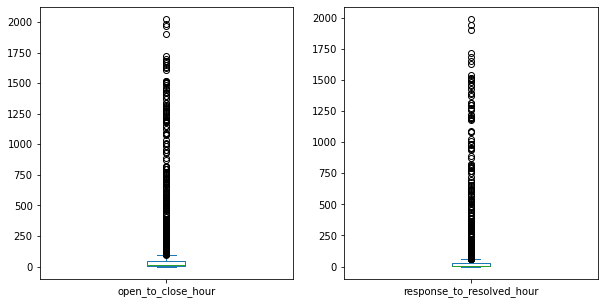

In [22]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

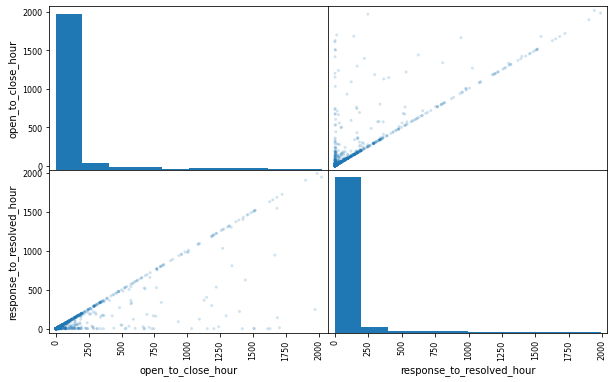

In [23]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

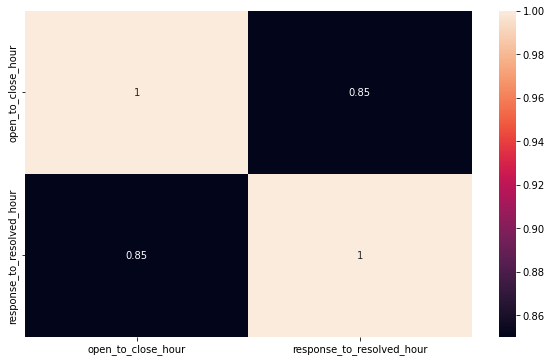

In [24]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Manage Categorical Cols

In [25]:
VBar=['brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]
HBar.insert(0,'severity_name')

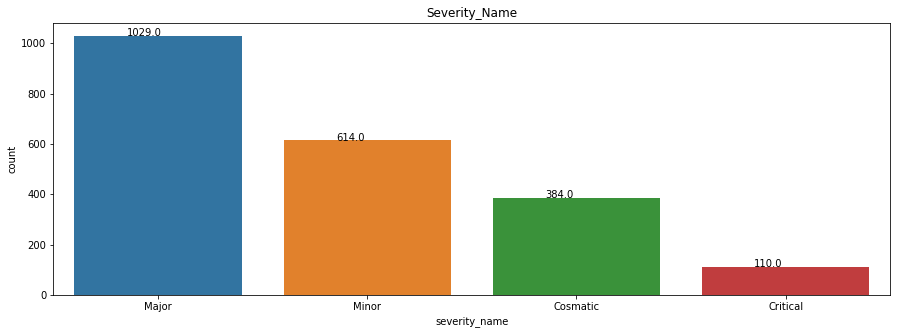

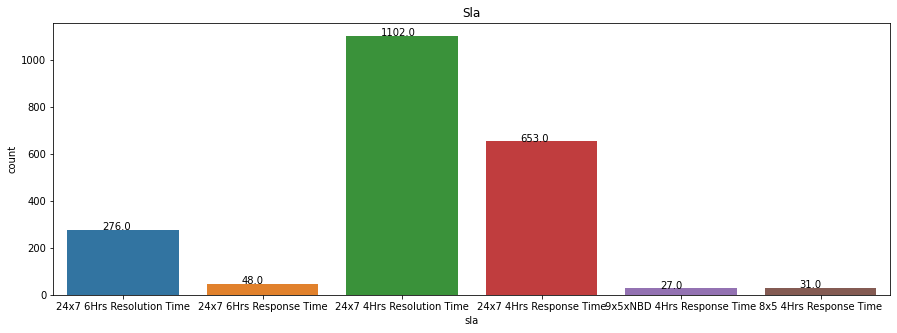

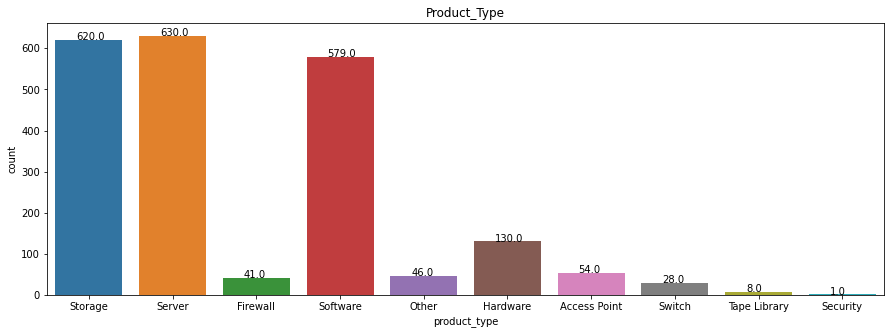

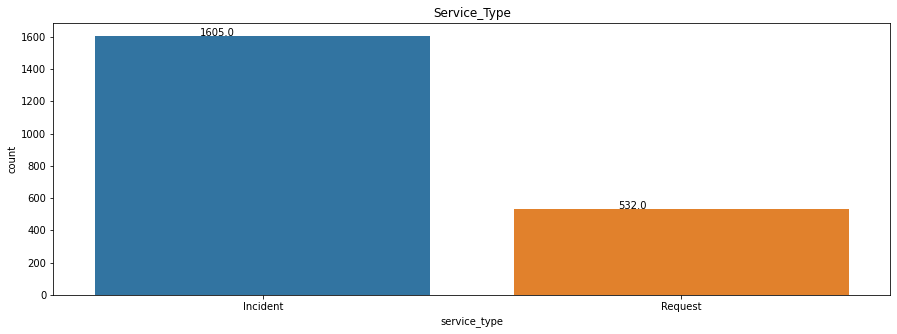

In [26]:
for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

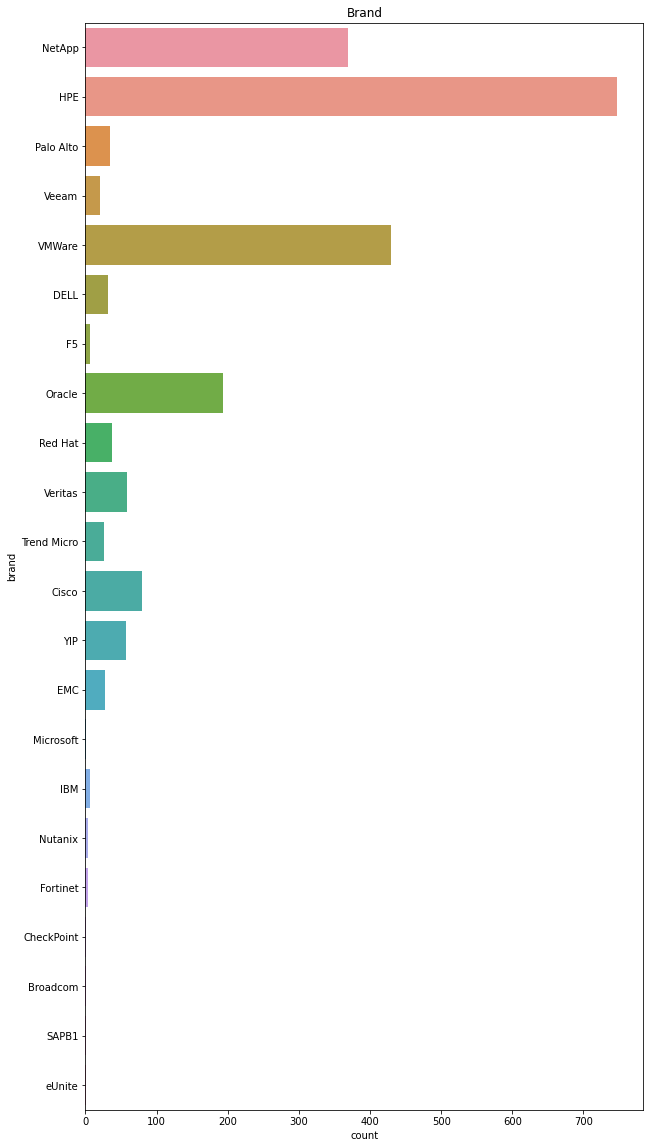

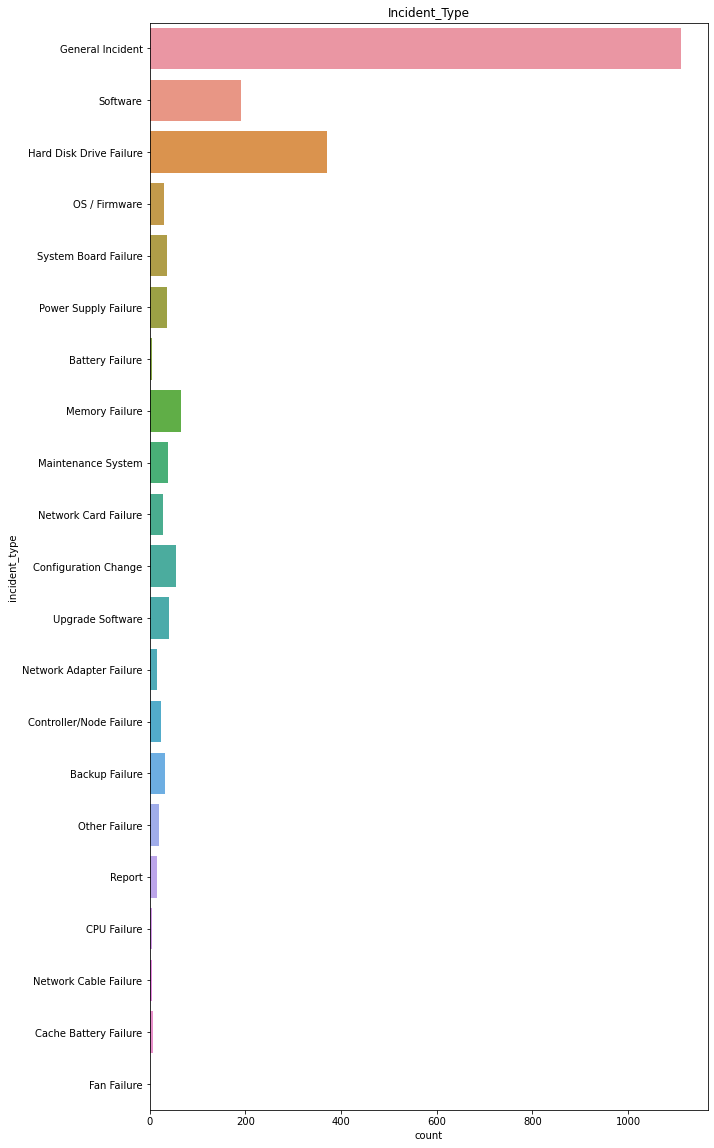

In [27]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

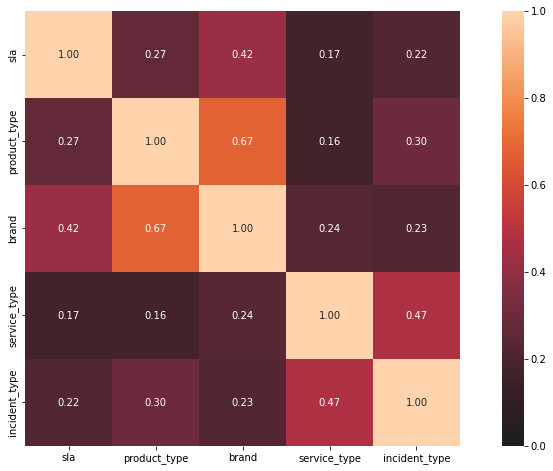

In [28]:
complete_correlation= associations(df_all[ [x for x in list(df_all.columns) if x not in ['severity_id','severity_name']+numbericCols]  ], figsize=(15,8))

In [29]:
# df_all['severity'] =df_all['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3})       


# def map_4to2_serverity(severity_id):
#     if severity_id==1 or severity_id==2:
#        return 1
#     else:
#        return 0 
# df_all['severity'] =df_all['severity_id'].apply(map_4to2_serverity)


# df_all=df_all.drop(columns=['severity_name','severity_id'])
    
# df_all.info()

# print(df_all['severity'].unique())
# df_all.tail()

In [30]:
if to_where=='local' and is_splited==False:
    print("Save to local and not split")
    df_all.to_csv("data/TrainEval_Incident.csv",index=False)
elif  to_where=='local' and is_splited==True:
    print("Save to local and split")
    df_train = df_all.sample(frac = 0.8, random_state=100)
    df_train.to_csv("data/Train_Incident_BiClass.csv",index=False)
    df_test = df_all.drop(df_train.index)
    df_test.to_csv("data/Eval_Incident_BiClass.csv",index=False)
else:
    print("No option")


Save to local and not split


In [136]:
# train_csv_file='Incident.csv'
# if to_where=='local':
#    df.to_csv(f"data/{train_csv_file}",index=False)  
# elif to_where=='gcs':
#    gcs_path="gs://smart-ml-pongthorn"
#    df.to_csv(f"{gcs_path}/{train_csv_file}",index=False) -

In [137]:
df_train.shape

(1703, 9)

In [140]:
df_test.shape

(426, 9)